student:chen tetroashvili,id:212997944,email:chenush270@gmail.com,I chose the applied track in the field of Cybersecurity

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from typing import Optional, List
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold


df = pd.read_csv("packets_test.csv")
dc=pd.read_csv("packets_train.csv")

print(df.head())
print(dc.head())


    timestamp         src_ip      dst_ip protocol  ttl  packet_length  \
0  1700002175  192.168.2.238   10.0.2.45      TCP   59           1230   
1  1700001578  192.168.3.189  10.0.7.120     ICMP   70           1169   
2  1700001252  192.168.0.223   10.0.2.69      TCP  105            827   
3  1700000848  192.168.1.135   10.0.1.93      TCP   80            742   
4  1700001491   192.168.2.67  10.0.3.170      TCP  113           1273   

   tcp_syn  tcp_ack  tcp_fin       label  
0        1        0        0  no_anomaly  
1        0        0        0  no_anomaly  
2        0        1        0  no_anomaly  
3        0        0        0  no_anomaly  
4        0        0        0  no_anomaly  
    timestamp         src_ip      dst_ip protocol  ttl  packet_length  \
0  1700000828   192.168.0.21   10.0.1.54      UDP  117           1046   
1  1700002005   192.168.1.37  10.0.6.187      TCP   41            405   
2  1700000143  192.168.2.248  10.0.5.239      TCP   91            799   
3  17000023

In [76]:

print("Train shape:", dc.shape)
print("Test shape:", df.shape)


print("Train columns:", dc.columns.tolist())
print("Test columns:", df.columns.tolist())


print(dc.info())



Train shape: (9600, 10)
Test shape: (2400, 10)
Train columns: ['timestamp', 'src_ip', 'dst_ip', 'protocol', 'ttl', 'packet_length', 'tcp_syn', 'tcp_ack', 'tcp_fin', 'label']
Test columns: ['timestamp', 'src_ip', 'dst_ip', 'protocol', 'ttl', 'packet_length', 'tcp_syn', 'tcp_ack', 'tcp_fin', 'label']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   timestamp      9600 non-null   int64 
 1   src_ip         9600 non-null   object
 2   dst_ip         9600 non-null   object
 3   protocol       9600 non-null   object
 4   ttl            9600 non-null   int64 
 5   packet_length  9600 non-null   int64 
 6   tcp_syn        9600 non-null   int64 
 7   tcp_ack        9600 non-null   int64 
 8   tcp_fin        9600 non-null   int64 
 9   label          9600 non-null   object
dtypes: int64(6), object(4)
memory usage: 750.1+ KB
None


In [77]:

print(dc["label"].value_counts())


label
no_anomaly    9526
suspicious      45
anomaly         29
Name: count, dtype: int64


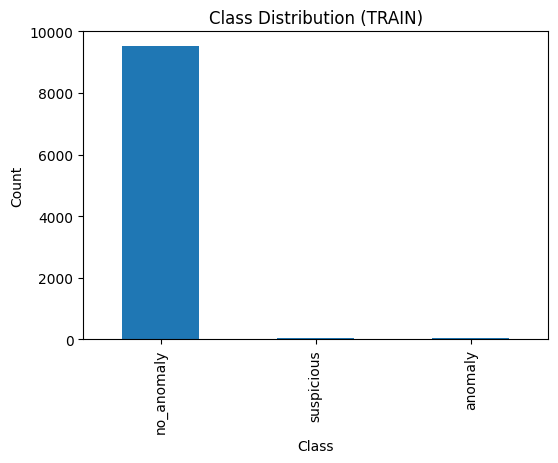

In [78]:


plt.figure(figsize=(6,4))
dc["label"].value_counts().plot(kind="bar")
plt.title("Class Distribution (TRAIN)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


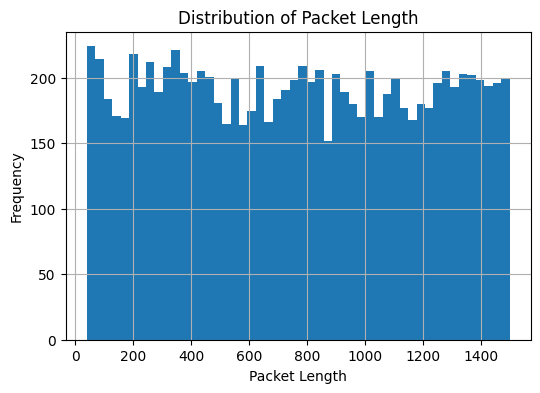

In [79]:
plt.figure(figsize=(6,4))
dc["packet_length"].hist(bins=50)
plt.title("Distribution of Packet Length")
plt.xlabel("Packet Length")
plt.ylabel("Frequency")
plt.show()


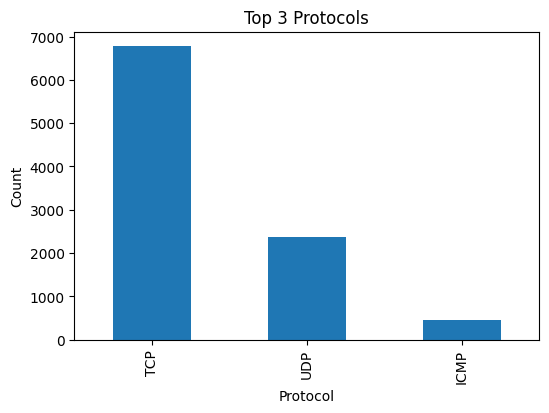

In [80]:

    plt.figure(figsize=(6,4))
    dc["protocol"].value_counts().head(3).plot(kind="bar")
    plt.title("Top 3 Protocols")
    plt.xlabel("Protocol")
    plt.ylabel("Count")
    plt.show()


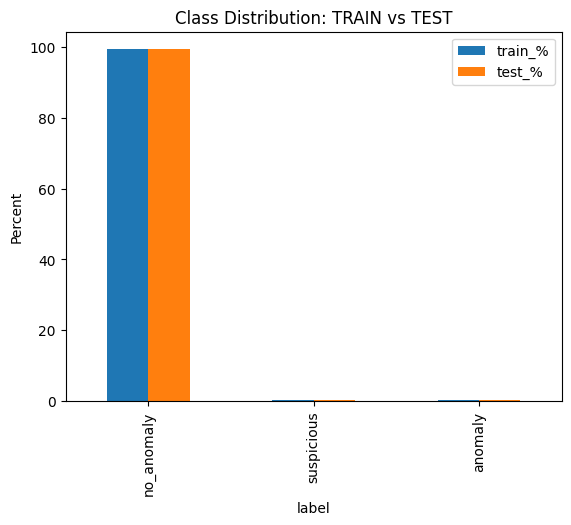

In [81]:
if "label" in dc.columns and "label" in df.columns:
    comp = pd.DataFrame({
        "train_%": (dc["label"].value_counts(normalize=True) * 100).round(2),
        "test_%":  (df["label"].value_counts(normalize=True) * 100).round(2)
    }).fillna(0)

    comp.plot(kind="bar")
    plt.title("Class Distribution: TRAIN vs TEST")
    plt.ylabel("Percent")
    plt.show()


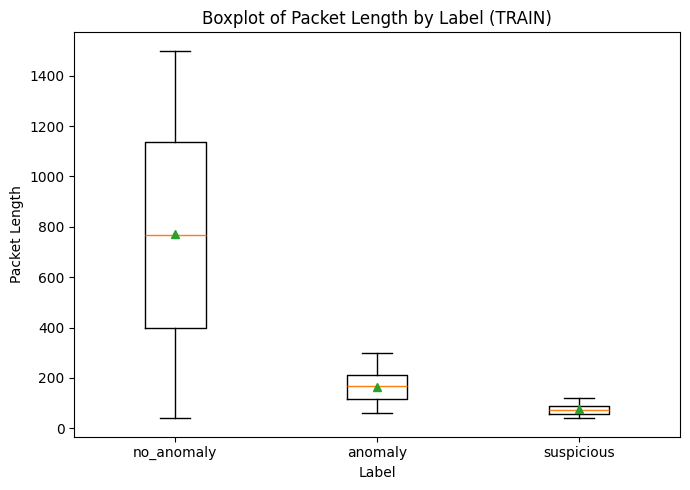

In [82]:



data_by_label = []

for lab in dc["label"].dropna().unique():

    mask = (dc["label"] == lab)


    series = dc.loc[mask, "packet_length"]
    series_no_na = series.dropna()

    arr = series_no_na.values

    data_by_label.append(arr)

plt.figure(figsize=(7,5))
plt.boxplot(data_by_label, labels=dc["label"].dropna().unique(), showmeans=True)
plt.title("Boxplot of Packet Length by Label (TRAIN)")
plt.xlabel("Label")
plt.ylabel("Packet Length")
plt.tight_layout()
plt.show()


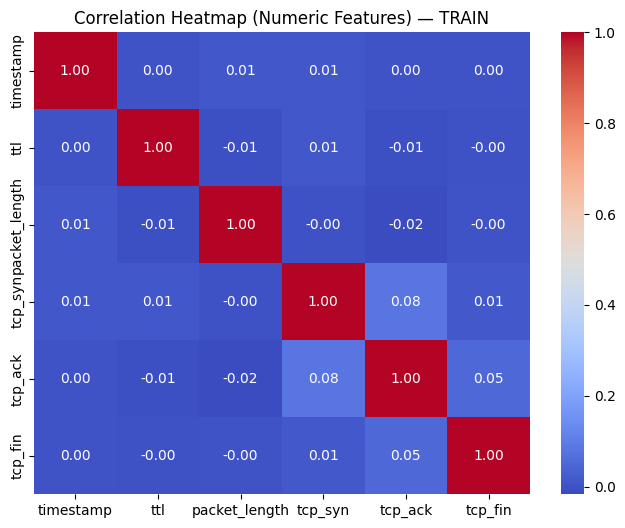

In [83]:

numeric_cols = dc.select_dtypes(include="number")
corr = numeric_cols.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features) — TRAIN")
plt.show()


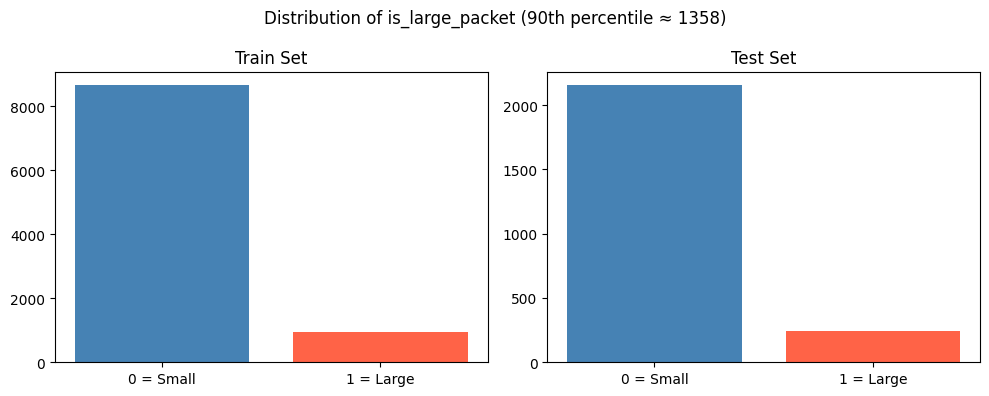

In [84]:

LENGTH_COL = "packet_length"
LARGE_PKT_THRESH = pd.to_numeric(dc[LENGTH_COL], errors="coerce").quantile(0.90)

for d in (dc, df):
    tmp = pd.to_numeric(d[LENGTH_COL], errors="coerce")
    d["is_large_packet"] = (tmp > LARGE_PKT_THRESH).astype(int)

# === ציור גרף השוואתי ===
counts_train = dc["is_large_packet"].value_counts().sort_index()
counts_test  = df["is_large_packet"].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(10,4))

axes[0].bar([0,1], counts_train.values, color=["steelblue","tomato"])
axes[0].set_xticks([0,1])
axes[0].set_xticklabels(["0 = Small", "1 = Large"])
axes[0].set_title("Train Set")

axes[1].bar([0,1], counts_test.values, color=["steelblue","tomato"])
axes[1].set_xticks([0,1])
axes[1].set_xticklabels(["0 = Small", "1 = Large"])
axes[1].set_title("Test Set")

plt.suptitle(f"Distribution of is_large_packet (90th percentile ≈ {LARGE_PKT_THRESH:.0f})")
plt.tight_layout()
plt.show()



In [85]:


class AppFeatureEngineer(BaseEstimator, TransformerMixin):

    def __init__(self,
                 timestamp_col: str = "timestamp",
                 protocol_col: str = "protocol",
                 ttl_col: str = "ttl",
                 src_ip_col: str = "src_ip",
                 dst_ip_col: str = "dst_ip",
                 length_col: str = "packet_length",
                 tcp_flags: Optional[List[str]] = None,
                 ttl_bins: List[float] = None,
                 ttl_labels: List[str] = None,
                 large_packet_quantile: float = 0.90):
        self.timestamp_col = timestamp_col
        self.protocol_col = protocol_col
        self.ttl_col = ttl_col
        self.src_ip_col = src_ip_col
        self.dst_ip_col = dst_ip_col
        self.length_col = length_col
        self.tcp_flags = tcp_flags or ["tcp_syn", "tcp_ack", "tcp_fin"]
        self.ttl_bins = ttl_bins or [-np.inf, 32, 64, 128, np.inf]
        self.ttl_labels = ttl_labels or ["vlow", "low", "mid", "high"]
        self.large_packet_quantile = large_packet_quantile

        # יאוכלסו ב-fit
        self.src_ip_freq_map_ = None
        self.dst_ip_freq_map_ = None
        self.large_pkt_thresh_ = None

    def fit(self, X: pd.DataFrame, y=None):
        X = X.copy()

        # חישוב שכיחויות IP (רק על TRAIN)
        if self.src_ip_col in X.columns:
            self.src_ip_freq_map_ = X[self.src_ip_col].value_counts(dropna=False, normalize=True)
        if self.dst_ip_col in X.columns:
            self.dst_ip_freq_map_ = X[self.dst_ip_col].value_counts(dropna=False, normalize=True)

        # סף לחבילה גדולה מה-TRAIN
        if self.length_col in X.columns:
            length = pd.to_numeric(X[self.length_col], errors="coerce")
            self.large_pkt_thresh_ = float(length.quantile(self.large_packet_quantile))

        return self

    def transform(self, X: pd.DataFrame):
        df2 = X.copy()


        if self.timestamp_col in df2.columns:
            ts = pd.to_datetime(df2[self.timestamp_col], unit="s", errors="coerce")
            df2["hour"] = ts.dt.hour.astype("Int64")
            df2["dow"]  = ts.dt.dayofweek.astype("Int64")


        if self.protocol_col in df2.columns:
            df2["is_tcp"] = (df2[self.protocol_col].astype(str).str.upper() == "TCP").astype(int)


        existing_flags = [f for f in self.tcp_flags if f in df2.columns]
        for flag in existing_flags:
            df2[flag] = pd.to_numeric(df2[flag], errors="coerce").fillna(0).astype(int)

        if all(f in df2.columns for f in ["tcp_syn", "tcp_ack", "tcp_fin"]):
            df2["tcp_flag_sum"] = df2[["tcp_syn", "tcp_ack", "tcp_fin"]].sum(axis=1)
            df2["syn_ack_combo"] = ((df2["tcp_syn"] == 1) & (df2["tcp_ack"] == 1)).astype(int)

        if self.ttl_col in df2.columns:
            ttl = pd.to_numeric(df2[self.ttl_col], errors="coerce")
            df2["ttl_bucket"] = pd.cut(ttl, bins=self.ttl_bins, labels=self.ttl_labels)


        if (self.src_ip_col in df2.columns) and (self.src_ip_freq_map_ is not None):
            df2[f"{self.src_ip_col}_freq"] = df2[self.src_ip_col].map(self.src_ip_freq_map_).fillna(0.0).astype(float)
        if (self.dst_ip_col in df2.columns) and (self.dst_ip_freq_map_ is not None):
            df2[f"{self.dst_ip_col}_freq"] = df2[self.dst_ip_col].map(self.dst_ip_freq_map_).fillna(0.0).astype(float)


        if (self.length_col in df2.columns) and (self.large_pkt_thresh_ is not None):
            length = pd.to_numeric(df2[self.length_col], errors="coerce")
            df2["is_large_packet"] = (length > self.large_pkt_thresh_).astype(int)

        return df2

In [90]:


# בחירה אוטומטית לפי סוג העמודות
num_sel = selector(dtype_include=np.number)
cat_sel = selector(dtype_exclude=np.number)


try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True, min_frequency=0.01)
except TypeError:
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=True, max_categories=30)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

# נומרי: חוסרים + (אופציונלי) נרמול
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", "passthrough"),
])

# קטגוריאלי: חוסרים + One-Hot
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe),
])

# מאחדים לשלב קדם-עיבוד אחד
preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_sel),
    ("cat", categorical_pipe, cat_sel),
])

# טרנספורמר שממיר Sparse ל-Dense
to_dense = FunctionTransformer(
    lambda X: X.todense() if hasattr(X, "todense") else X,
    accept_sparse=True
)



In [87]:

TARGET = "label"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X_train = dc.drop(columns=[TARGET])
y_train = dc[TARGET].astype(str)


eng_on  = AppFeatureEngineer(large_packet_quantile=0.90)
eng_off = "passthrough"


pipe = Pipeline([
    ("fe", eng_off),
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=2000, solver="saga",
                                 class_weight="balanced", random_state=42)),
])

# --- param grid (FE on/off + סקיילר + לוגיסטי עם 2 היפרים) ---
param_grid = [{
    "fe": [eng_on, eng_off],
    "prep__num__scaler": [StandardScaler(), "passthrough"],
    "model": [LogisticRegression(max_iter=2000, solver="saga",
                                 class_weight="balanced", random_state=42)],
    "model__C": [0.1, 1.0],                            # היפר 1
    "model__penalty": ["l1", "l2"],                    # היפר 2
}]

# --- info: combinations ---
total_combos = sum(len(list(ParameterGrid(g))) for g in param_grid)
print("מס׳ קומבינציות בגריד:", total_combos)
print("מס׳ אימונים עם 5-Fold:", total_combos * 5)

# --- GridSearchCV ---
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=False,
)

print("מתחיל GridSearchCV...")
gs.fit(X_train, y_train)
print("סיום GridSearchCV.")

# --- CV summary ---
cv_results = pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)
view_cols = ["rank_test_score", "mean_test_score", "std_test_score", "params"]
cv_table = cv_results[view_cols].copy()
cv_table["mean_test_score"] = cv_table["mean_test_score"].round(4)
cv_table["std_test_score"]  = cv_table["std_test_score"].round(4)
print("\n=== TOP 10 (CV) ===")
print(cv_table.head(10).to_string(index=False))

print("\n=== BEST CONFIG (CV) ===")
print("F1-macro (CV):", round(gs.best_score_, 4))
print("Params:", gs.best_params_)




מס׳ קומבינציות בגריד: 16
מס׳ אימונים עם 5-Fold: 80
מתחיל GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
סיום GridSearchCV.

=== TOP 10 (CV) ===
 rank_test_score  mean_test_score  std_test_score                                                                                                                                                                                                                                                                                                                                                                                              params
               1           0.3676          0.0207 {'fe': AppFeatureEngineer(tcp_flags=['tcp_syn', 'tcp_ack', 'tcp_fin'],
                   ttl_bins=[-inf, 32, 64, 128, inf],
                   ttl_labels=['vlow', 'low', 'mid', 'high']), 'model': LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42,
                   solver='saga'), 'model__C': 1.0, 'model__penal

נשמר קובץ: test_predictions.csv

ממוצעי אינדיקטורים לפי מחלקה חזויה:
                 tcp_flag_sum  syn_ack_combo  is_tcp
predicted_label                                     
anomaly                 1.045          0.220   0.890
no_anomaly              0.295          0.013   0.685
suspicious              0.310          0.000   0.717

F1-macro (TEST): 0.3419

Classification Report (TEST):

              precision    recall  f1-score   support

     anomaly     0.0172    0.7143    0.0336         7
  no_anomaly     1.0000    0.8383    0.9120      2381
  suspicious     0.0442    0.4167    0.0800        12

    accuracy                         0.8358      2400
   macro avg     0.3538    0.6564    0.3419      2400
weighted avg     0.9924    0.8358    0.9053      2400



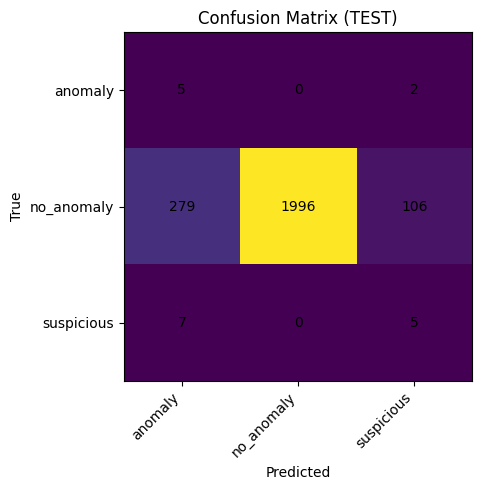

In [88]:
best_model = gs.best_estimator_

# הכנה ל-test
has_test_labels = TARGET in df.columns
X_test = df.drop(columns=[TARGET]) if has_test_labels else df.copy()
y_test = df[TARGET].astype(str) if has_test_labels else None

# תחזיות
test_pred = best_model.predict(X_test)

# שמירת תחזיות
pred_df = df.copy()
pred_df["predicted_label"] = test_pred
pred_df.to_csv("test_predictions.csv", index=False)
print("נשמר קובץ: test_predictions.csv")

# --- בדיקת איכות ייעודית (על אותם פיצ'רים של ההנדסה) ---
try:
    # נשלוף את מהנדס הפיצ'רים מתוך ה-Pipeline אם קיים
    fe_step = None
    if hasattr(best_model, "named_steps") and "fe" in best_model.named_steps:
        fe_step = best_model.named_steps["fe"]

    if fe_step is not None and hasattr(fe_step, "transform"):
        df_eval = fe_step.transform(df.copy())
    else:

        df_eval = add_app_features(df.copy())

    df_eval["predicted_label"] = test_pred
    cols = [c for c in ["tcp_flag_sum", "syn_ack_combo", "is_tcp"] if c in df_eval.columns]
    if cols:
        print("\nממוצעי אינדיקטורים לפי מחלקה חזויה:")
        print(df_eval.groupby("predicted_label")[cols].mean().round(3))
except Exception as e:
    print("לא ניתן לחשב בדיקת אינדיקטורים —", e)


if has_test_labels:
    test_f1 = f1_score(y_test, test_pred, average="macro")
    print("\nF1-macro (TEST):", round(test_f1, 4))
    print("\nClassification Report (TEST):\n")
    print(classification_report(y_test, test_pred, digits=4))

    # איחוד התוויות כדי לא לפספס מקרים חדשים ב-test
    labels_order = sorted(pd.unique(pd.concat([y_train, y_test], ignore_index=True)))

    cm = confusion_matrix(y_test, test_pred, labels=labels_order)
    plt.figure(figsize=(6,5))
    plt.imshow(cm)
    plt.xticks(np.arange(len(labels_order)), labels_order, rotation=45, ha="right")
    plt.yticks(np.arange(len(labels_order)), labels_order)
    plt.xlabel("Predicted"); plt.ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.title("Confusion Matrix (TEST)")
    plt.tight_layout()
    plt.show()



In [89]:

if has_test_labels:
    preview = pd.DataFrame({
        "y_true": y_test.iloc[:5].values,
        "y_pred": test_pred[:5]
    })
else:
    preview = pd.DataFrame({"y_pred": test_pred[:5]})
print(" First 5 predicted labels:")
print(preview)


 First 5 predicted labels:
       y_true      y_pred
0  no_anomaly  no_anomaly
1  no_anomaly  no_anomaly
2  no_anomaly  no_anomaly
3  no_anomaly  no_anomaly
4  no_anomaly  no_anomaly
